# Data Analysis for CREMA-D Embeddings

Exploratory analysis of CREMA-D audio representations. This notebook visualizes raw waveforms and mel-spectrograms, inspects precomputed embeddings (ResNet18, VGG16, PANNs_cnn14), applies PCA, and evaluates lightweight baseline classifiers for selected emotions.
    

In [1]:
# Environment setup: mount Drive and clone repository
# Mount Google Drive to access data stored in `/content/drive/MyDrive/CREMAD`
from google.colab import drive
drive.mount('/content/drive')
# Clone the repository (if necessary) and add `src` to the path
repo_path = '/content/qnn-transfer-learning'
import os
if not os.path.isdir(repo_path):
  %cd /content
  !git clone https://github.com/lburdman/qnn-transfer-learning.git
%cd qnn-transfer-learning

import sys
sys.path.append('src')


Mounted at /content/drive
/content
Cloning into 'qnn-transfer-learning'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 132 (delta 58), reused 104 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (132/132), 6.77 MiB | 9.57 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/qnn-transfer-learning


In [11]:

# Imports & configuration
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
except ImportError:
    torch = None

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10
})

DATA_ROOT = Path('/content/drive/MyDrive/CREMAD')
AUDIO_DIR = DATA_ROOT / 'AudioWAV'
SPLITS_DIR = DATA_ROOT / 'splits'
SPEC_DIR = DATA_ROOT / 'Spectrograms'
EMB_ROOT = DATA_ROOT / 'Embeddings'
MFCC_DIR = DATA_ROOT / 'MFCC'

TARGET_SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128

SELECTED_CLASSES = ['HAP', 'SAD', 'ANG', 'DIS', 'FEA', 'NEU'] # ['HAP', 'SAD', 'ANG', 'DIS', 'FEA', 'NEU']
SPLITS_TO_USE = ('val',)  # you can add 'val', 'test' if needed
EMBEDDING_PATHS = {
    'resnet18': EMB_ROOT / 'ResNet18',
    'vgg16': EMB_ROOT / 'VGG16',
    'panns_cnn14': EMB_ROOT / 'PANNs_Cnn14',
}
EMBEDDING_TYPES = list(EMBEDDING_PATHS.keys())
PCA_COMPONENTS_MAX = 50
MAX_VIZ_SAMPLES = 1500

from src.dataset import load_metadata, load_embeddings, load_mfcc_features
from src.analysis_utils import subsample_for_viz, resolve_tsne_perplexity, run_dim_reduction, run_baseline_classifiers
from src.plot_functions import plot_2d_projection, plot_confusion_matrix
from src.visualize_melspec import plot_waveform, plot_melspectrogram, plot_example_waveform_and_mel, plot_example_waveform_and_mfcc


In [ ]:
# Utility helpers are imported from src modules.

In [ ]:
# Dimensionality reduction helpers are imported from src.analysis_utils.

In [ ]:
# Waveform and mel-spectrogram helpers are imported from src.visualize_melspec.

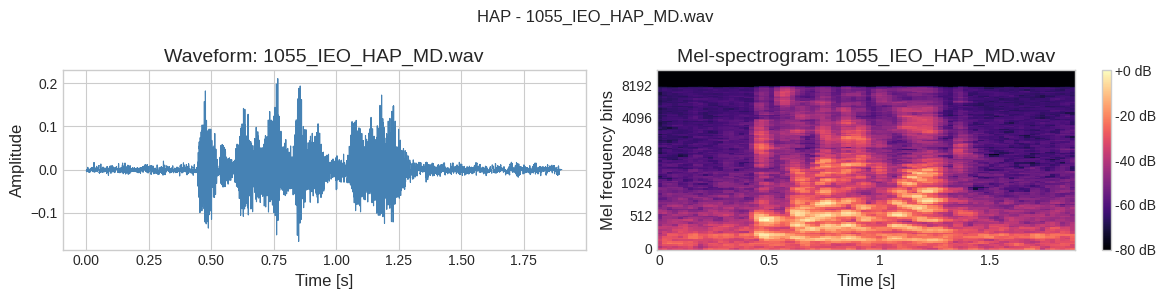

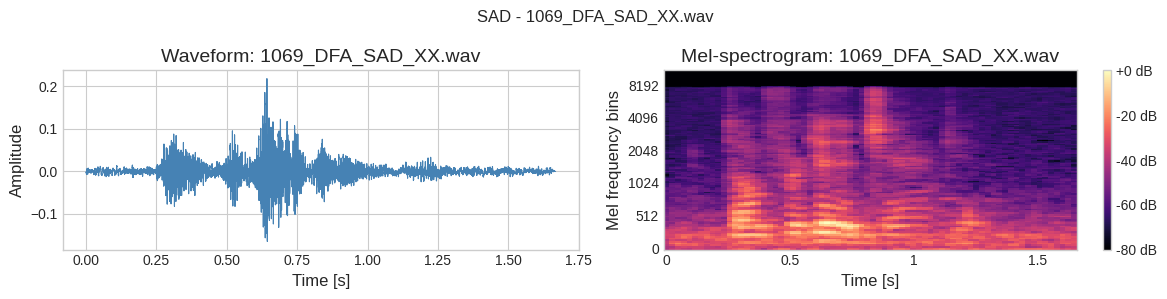

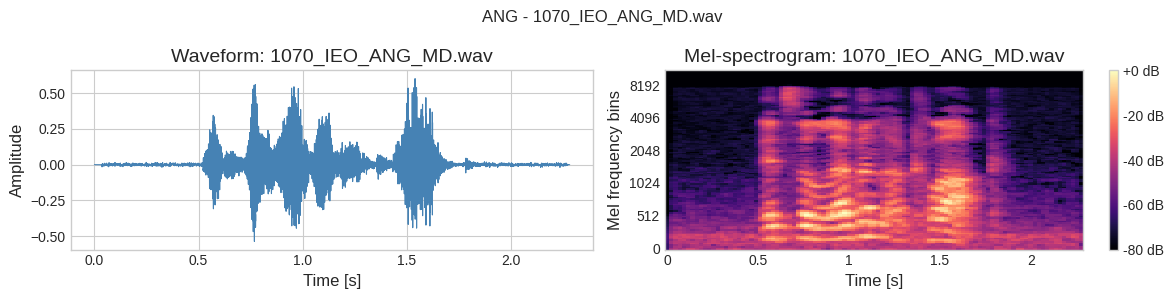

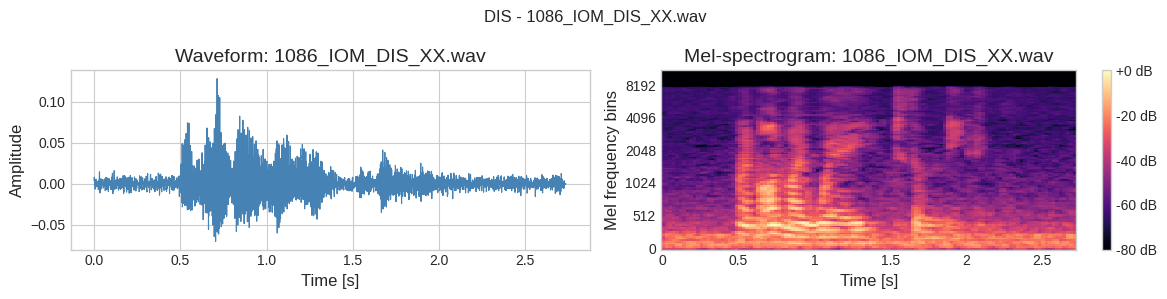

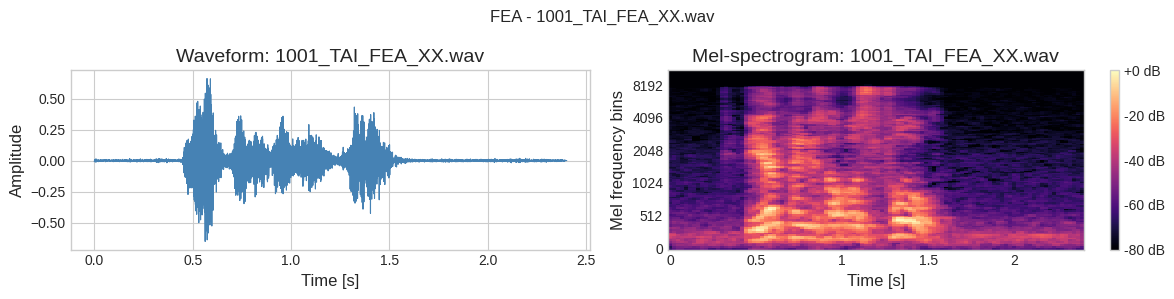

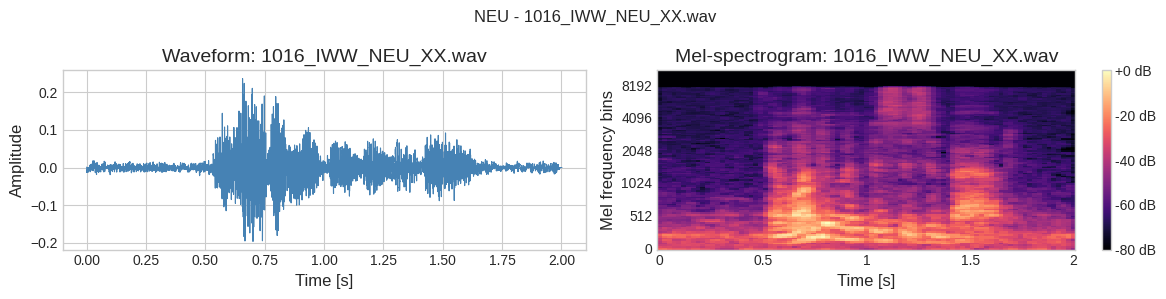

In [9]:
# Sample examples per class for waveform and mel views
meta_df = load_metadata(selected_classes=SELECTED_CLASSES, splits_dir=SPLITS_DIR, audio_dir=AUDIO_DIR)
examples = []
for cls in SELECTED_CLASSES:
    cls_df = meta_df[meta_df['label'] == cls]
    if cls_df.empty:
        continue
    n_show = min(1, len(cls_df))
    sampled = cls_df.sample(n=n_show, random_state=SEED)
    examples.append(sampled)

if examples:
    for _, row in pd.concat(examples).iterrows():
        plot_example_waveform_and_mel(row)
else:
    print('No examples available for the selected classes.')



=== resnet18 ===
Samples: 1387 | Embedding dimension: 512
Class distribution:
SAD    243
DIS    239
ANG    238
HAP    236
FEA    223
NEU    208
Name: count, dtype: int64


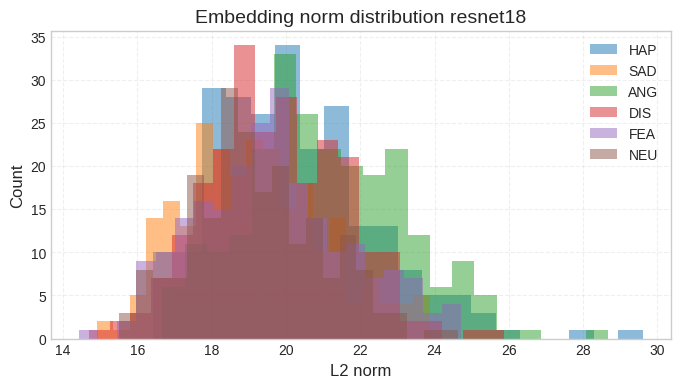

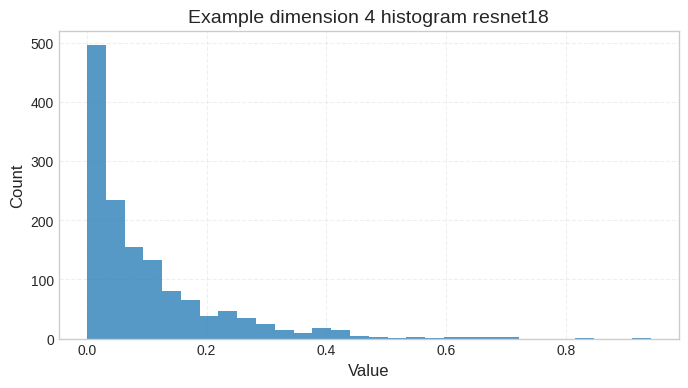


=== vgg16 ===
Samples: 1387 | Embedding dimension: 4096
Class distribution:
SAD    243
DIS    239
ANG    238
HAP    236
FEA    223
NEU    208
Name: count, dtype: int64


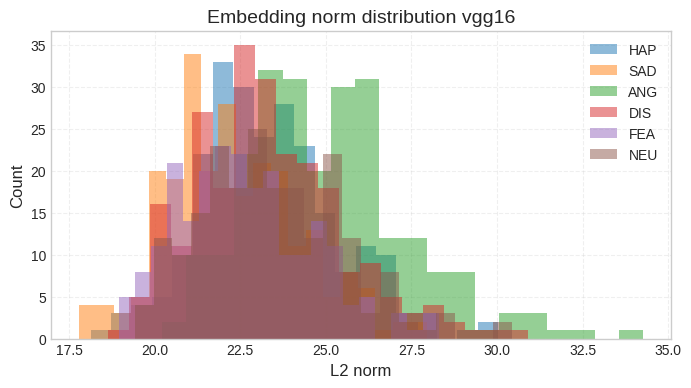

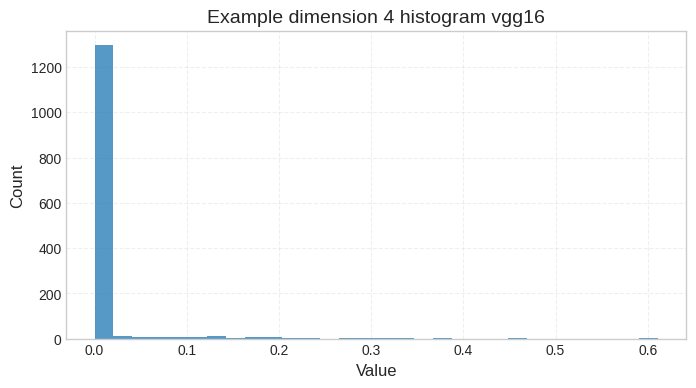


=== panns_cnn14 ===
Samples: 1387 | Embedding dimension: 2048
Class distribution:
SAD    243
DIS    239
ANG    238
HAP    236
FEA    223
NEU    208
Name: count, dtype: int64


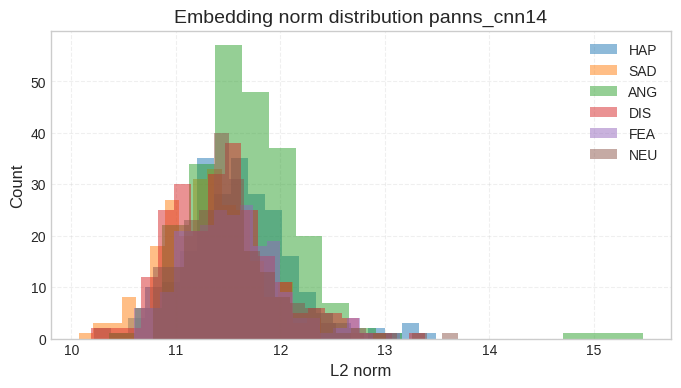

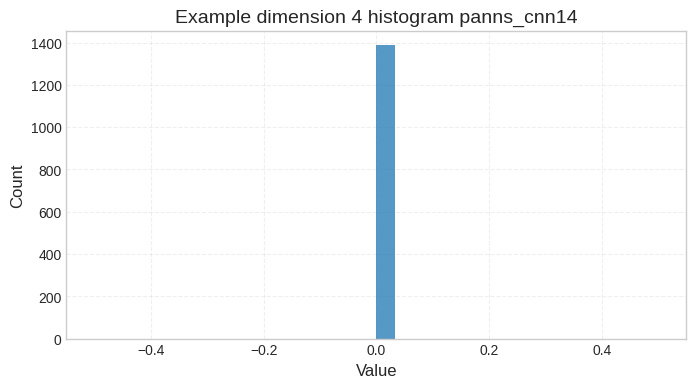

In [15]:
# Load embeddings and basic statistics
embedding_store = {}

for emb_type in EMBEDDING_TYPES:
    print(f'\n=== {emb_type} ===')
    X, y, meta = load_embeddings(emb_type, embedding_paths=EMBEDDING_PATHS, splits=SPLITS_TO_USE, selected_classes=SELECTED_CLASSES)
    embedding_store[emb_type] = {'X': X, 'y': y, 'meta': meta}

    print(f'Samples: {len(X)} | Embedding dimension: {X.shape[1]}')
    print('Class distribution:')
    print(pd.Series(y).value_counts())

    # Norm distribution per class
    norms = np.linalg.norm(X, axis=1)
    fig, ax = plt.subplots(figsize=(8, 4))
    for cls in SELECTED_CLASSES:
        mask = (y == cls)
        if mask.any():
            ax.hist(norms[mask], bins=20, alpha=0.5, label=cls)

    ax.set_title(f'Embedding norm distribution {emb_type}')
    ax.set_xlabel('L2 norm')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # Example histogram of a single embedding dimension
    dim_index = min(4, X.shape[1] - 1)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(X[:, dim_index], bins=30, alpha=0.75)
    ax.set_title(f'Example dimension {dim_index} histogram {emb_type}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()


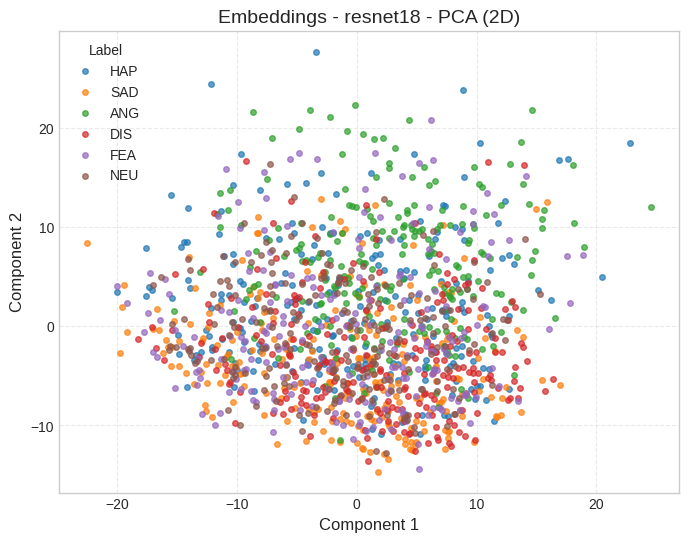

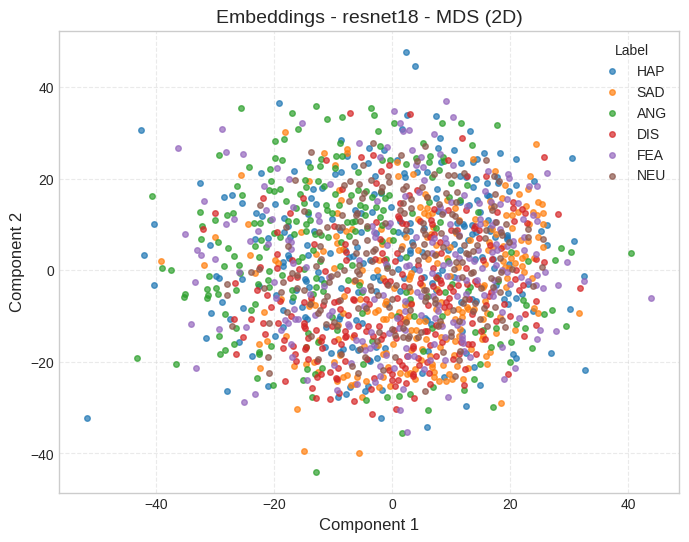

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


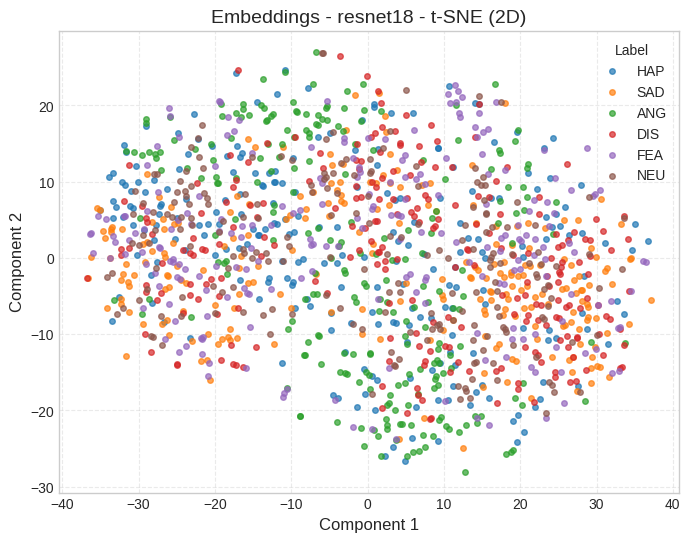

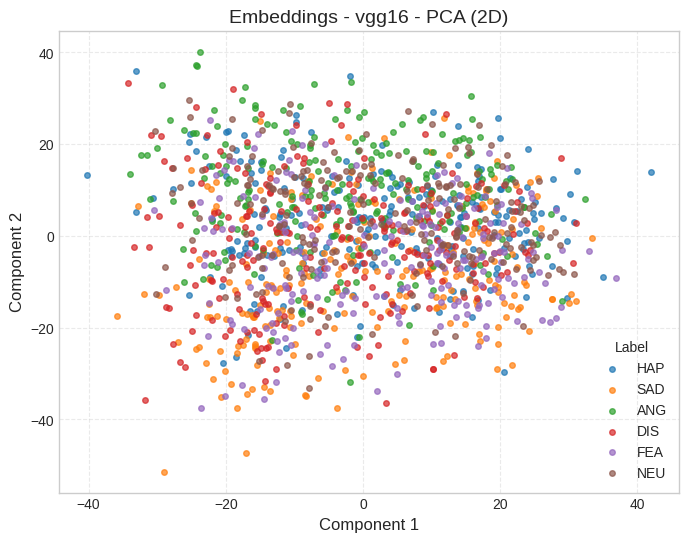

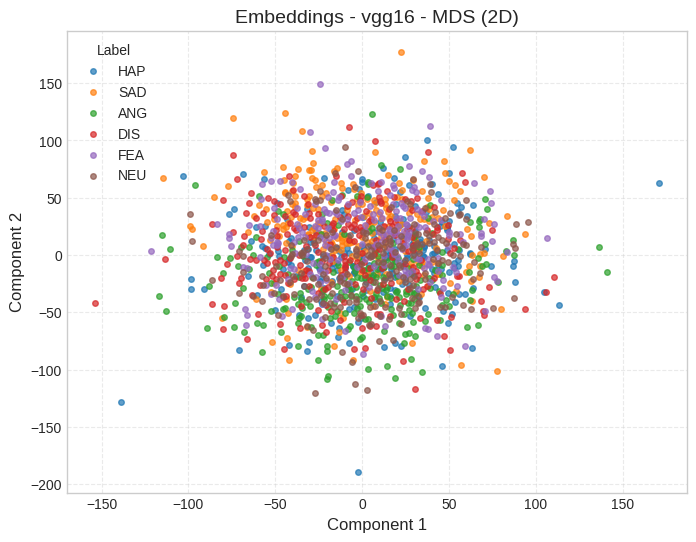

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


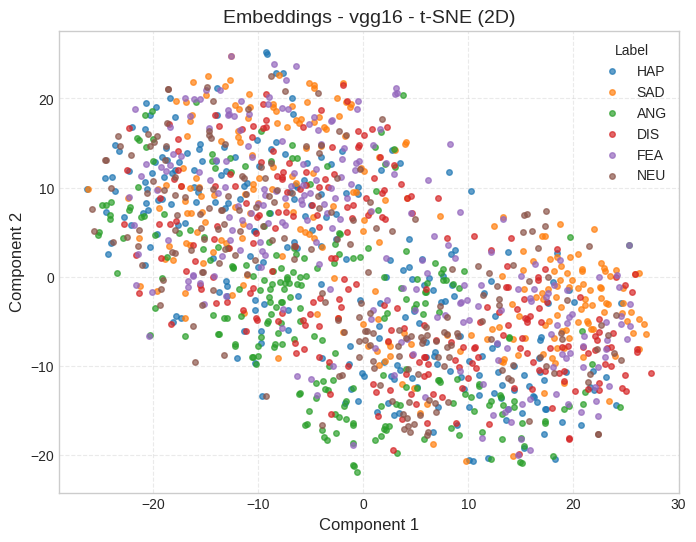

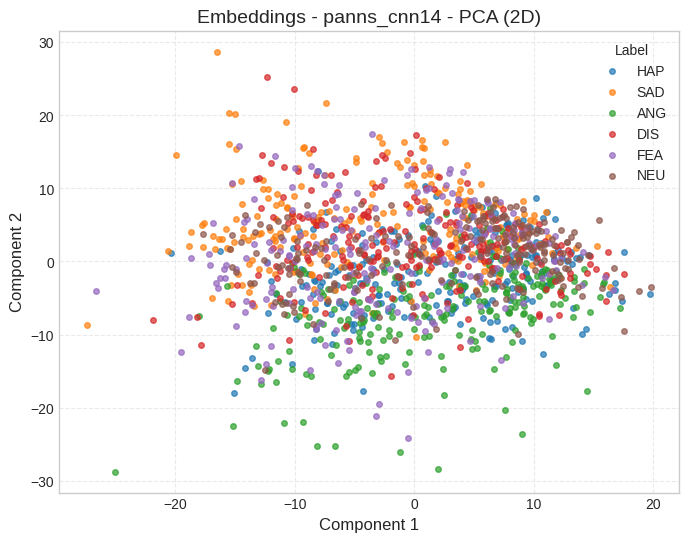

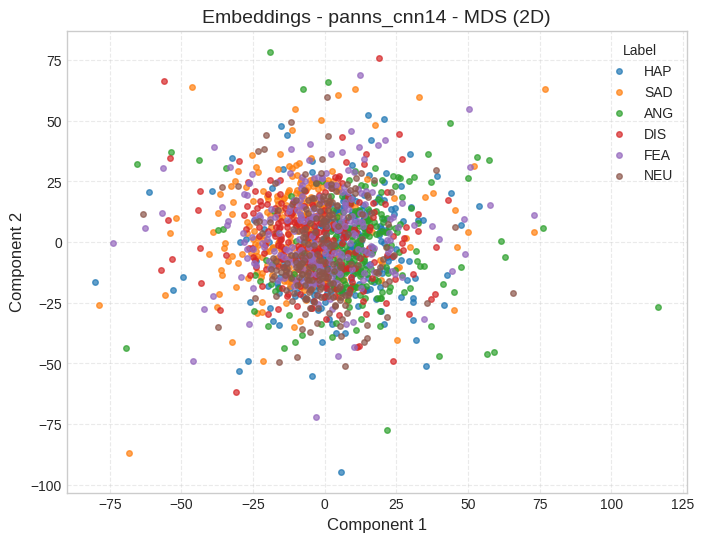

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


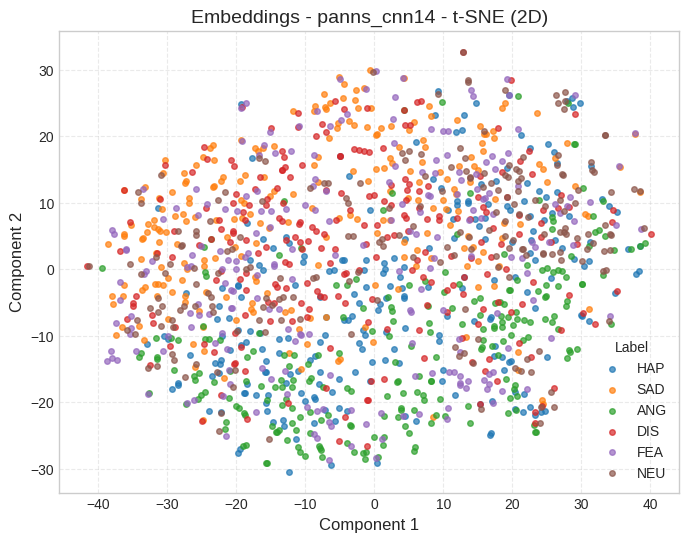

In [16]:

# Dimensionality reduction projections
pca_results = {}
for emb_type, payload in embedding_store.items():
    X, y = payload['X'], payload['y']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n_comp = min(PCA_COMPONENTS_MAX, X_scaled.shape[1], X_scaled.shape[0])
    pca, X_pca = run_dim_reduction(
        X_scaled,
        method='pca',
        n_components=n_comp,
        scale=False,
        random_state=SEED
    )
    pca_results[emb_type] = {'pca': pca, 'X_pca': X_pca, 'y': y}
    plot_2d_projection(X_pca[:, :2], y, title=f'Embeddings - {emb_type} - PCA (2D)', label_order=SELECTED_CLASSES)

    X_sub, y_sub, _ = subsample_for_viz(X_scaled, y, max_samples=MAX_VIZ_SAMPLES, random_state=SEED)
    _, X_mds = run_dim_reduction(
        X_sub,
        method='mds',
        n_components=2,
        scale=False,
        random_state=SEED,
        n_init=4,
        max_iter=300
    )
    plot_2d_projection(X_mds, y_sub, title=f'Embeddings - {emb_type} - MDS (2D)', label_order=SELECTED_CLASSES)

    tsne_perp = resolve_tsne_perplexity(len(X_sub))
    _, X_tsne = run_dim_reduction(
        X_sub,
        method='tsne',
        n_components=2,
        scale=False,
        random_state=SEED,
        perplexity=tsne_perp,
        init='pca',
        learning_rate='auto',
        n_iter=1000
    )
    plot_2d_projection(X_tsne, y_sub, title=f'Embeddings - {emb_type} - t-SNE (2D)', label_order=SELECTED_CLASSES)


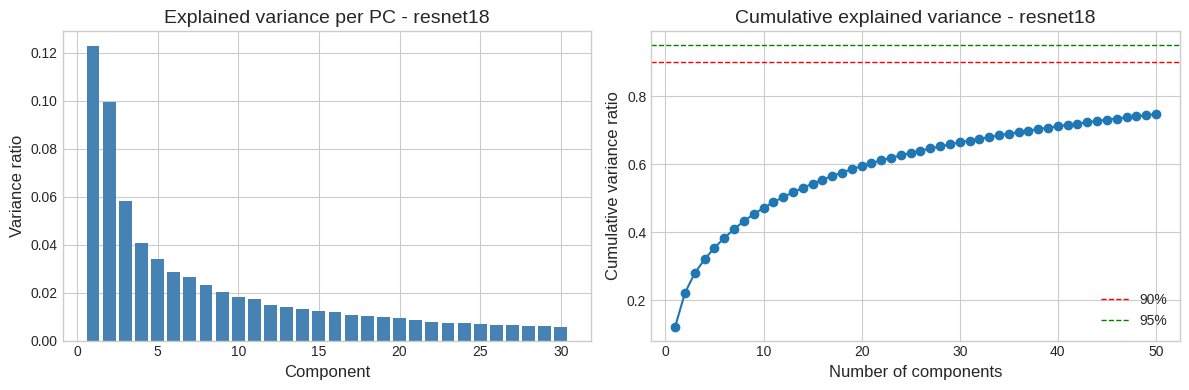

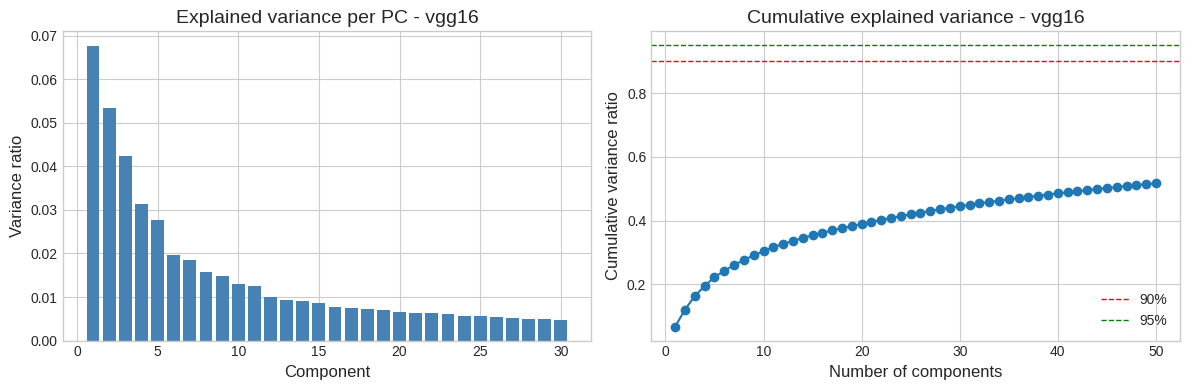

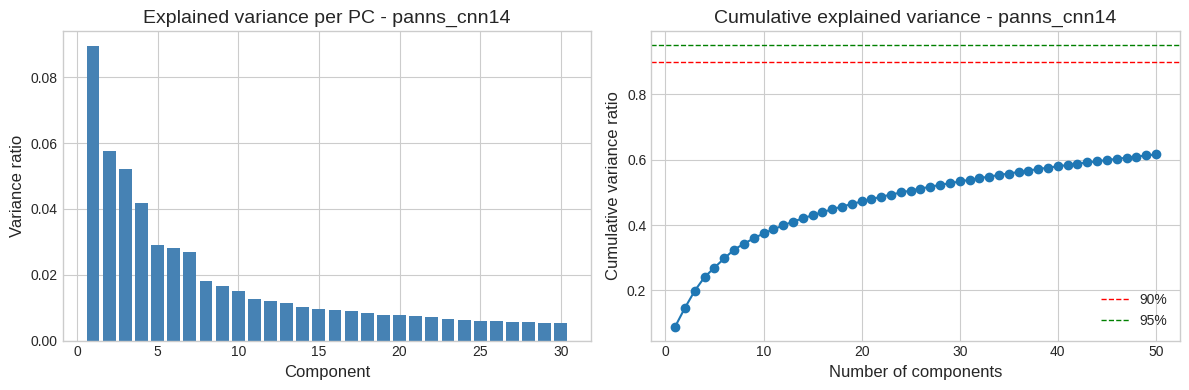

In [17]:

# Explained variance analysis
for emb_type, res in pca_results.items():
    pca = res['pca']
    evr = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    k = min(30, len(evr))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(range(1, k + 1), evr[:k], color='steelblue')
    axes[0].set_title(f'Explained variance per PC - {emb_type}')
    axes[0].set_xlabel('Component')
    axes[0].set_ylabel('Variance ratio')

    axes[1].plot(range(1, len(cum_evr) + 1), cum_evr, marker='o')
    axes[1].axhline(0.9, color='red', linestyle='--', linewidth=1, label='90%')
    axes[1].axhline(0.95, color='green', linestyle='--', linewidth=1, label='95%')
    axes[1].set_title(f'Cumulative explained variance - {emb_type}')
    axes[1].set_xlabel('Number of components')
    axes[1].set_ylabel('Cumulative variance ratio')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [21]:
from typing import Sequence, Tuple, Iterable, List
from pathlib import Path

import numpy as np
import pandas as pd


def _load_feature_arrays(
    base_dir: Path,
    splits: Iterable[str],
    selected_classes: Sequence[str] | None,
    preferred_keys: Sequence[str],
    flatten: bool = True,
    path_col_name: str = "feature_path",
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Load feature arrays stored under base_dir/split/label/*.npz or *.npy.

    If flatten=True:
        - All arrays are flattened to 1D and padded/truncated to the same length.
        - Returns X with shape (n_samples, n_features).

    If flatten=False:
        - If all arrays have the same shape, they are stacked.
        - Otherwise, X is an object array where X[i] is the original array.
    """
    if not base_dir.exists():
        raise FileNotFoundError(f"Feature directory not found: {base_dir}")

    if isinstance(splits, str):
        splits = (splits,)

    features: List[np.ndarray] = []
    labels: List[str] = []
    records: List[dict] = []
    load_errors: List[Tuple[str, str]] = []

    for split in splits:
        split_dir = base_dir / split
        if not split_dir.exists():
            print(f"[load_feature_arrays] Split directory not found, skipping: {split_dir}")
            continue

        for label_dir in sorted(split_dir.iterdir()):
            if not label_dir.is_dir():
                continue

            label = label_dir.name
            if selected_classes and label not in selected_classes:
                continue

            files = list(label_dir.glob("*.npz")) + list(label_dir.glob("*.npy"))
            if not files:
                continue

            for fpath in files:
                try:
                    data = np.load(fpath, allow_pickle=False)

                    # Handle .npz vs .npy
                    if isinstance(data, np.lib.npyio.NpzFile):
                        key = None
                        for candidate in preferred_keys:
                            if candidate in data.files:
                                key = candidate
                                break
                        if key is None:
                            key = data.files[0] if data.files else None
                        if key is None:
                            raise ValueError("Empty NPZ file")
                        arr = data[key]
                    else:
                        arr = data

                    arr = np.asarray(arr, dtype=np.float32)

                    # Flatten to 1D if requested
                    if flatten and arr.ndim > 1:
                        arr = arr.reshape(-1)

                    features.append(arr)
                    labels.append(label)
                    records.append({
                        path_col_name: str(fpath),
                        "split": split,
                        "label": label,
                        "file_stem": fpath.stem,
                    })
                except Exception as exc:  # pylint: disable=broad-except
                    load_errors.append((str(fpath), repr(exc)))
                    continue

    if not features:
        raise RuntimeError(f"No features loaded from {base_dir} with current filters.")

    if load_errors:
        print(f"[load_feature_arrays] {len(load_errors)} files failed to load from {base_dir}.")
        print("  Example errors:", load_errors[:3])

    # --------- build X ---------
    if flatten:
        # features are 1D arrays (possibly different lengths) -> pad/truncate
        lengths = [f.shape[0] for f in features]
        max_len = max(lengths)

        X = np.zeros((len(features), max_len), dtype=np.float32)
        for i, f in enumerate(features):
            L = min(f.shape[0], max_len)
            X[i, :L] = f[:L]

    else:
        # keep original shapes
        shapes = [f.shape for f in features]
        unique_shapes = set(shapes)

        if len(unique_shapes) == 1:
            X = np.stack(features)
        else:
            # variable shapes -> object array
            X = np.array(features, dtype=object)

    y = np.array(labels)
    meta_loaded = pd.DataFrame(records).reset_index(drop=True)
    return X, y, meta_loaded


def load_mfcc_features(
    splits: Iterable[str],
    mfcc_dir: Path,
    selected_classes: Sequence[str] | None,
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Load MFCC feature arrays stored under mfcc_dir/train|val|test/<label>/.

    - Each original MFCC is (40, T_i).
    - For analysis (PCA, etc.) we:
        * flatten to 1D
        * pad/truncate to a common length

    Returns:
        X: 2D array, shape (n_samples, n_features)
        y: label array
        meta: DataFrame with 'mfcc_path', 'split', 'label', 'file_stem'
    """
    return _load_feature_arrays(
        base_dir=mfcc_dir,
        splits=splits,
        selected_classes=selected_classes,
        preferred_keys=("mfcc", "feature", "features", "arr_0"),
        flatten=True,          # IMPORTANT: 2D X for StandardScaler / PCA
        path_col_name="mfcc_path",
    )


In [22]:

# Load MFCC features and basic statistics
mfcc_store = {}
try:
    X_mfcc, y_mfcc, meta_mfcc = load_mfcc_features(splits=SPLITS_TO_USE, mfcc_dir=MFCC_DIR, selected_classes=SELECTED_CLASSES)
    mfcc_store['mfcc'] = {'X': X_mfcc, 'y': y_mfcc, 'meta': meta_mfcc}

    print(f'Samples: {len(X_mfcc)} | MFCC dimension: {X_mfcc.shape[1]}')
    print('Class distribution:')
    print(pd.Series(y_mfcc).value_counts())
except Exception as e:
    print(f'Failed to load MFCC features: {e}')


Samples: 745 | MFCC dimension: 8360
Class distribution:
FEA    128
ANG    127
DIS    127
HAP    127
SAD    127
NEU    109
Name: count, dtype: int64


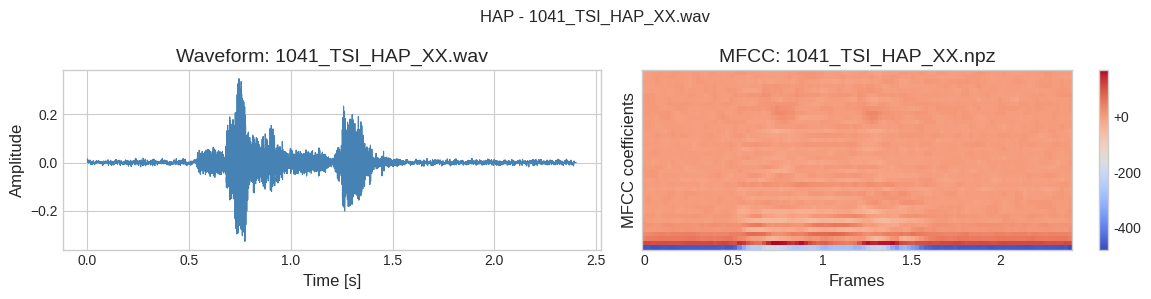

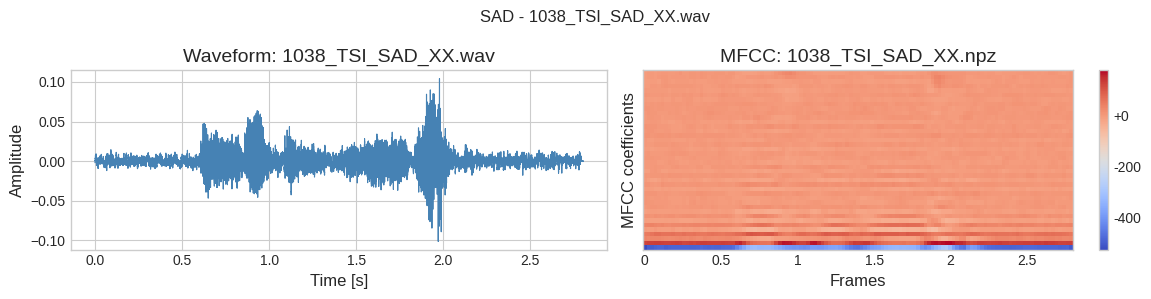

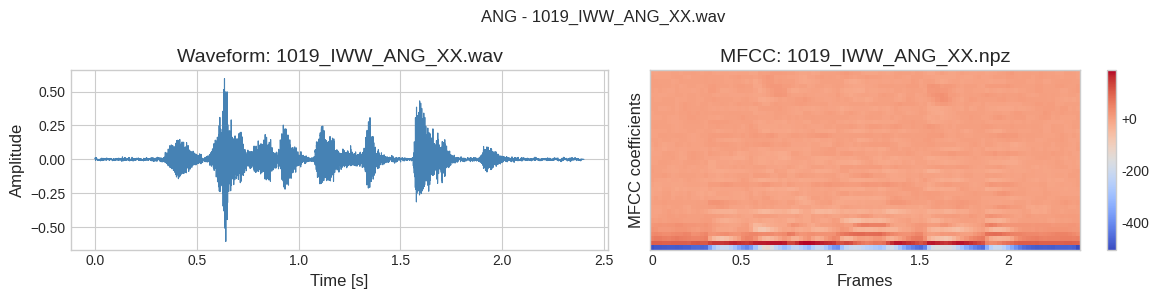

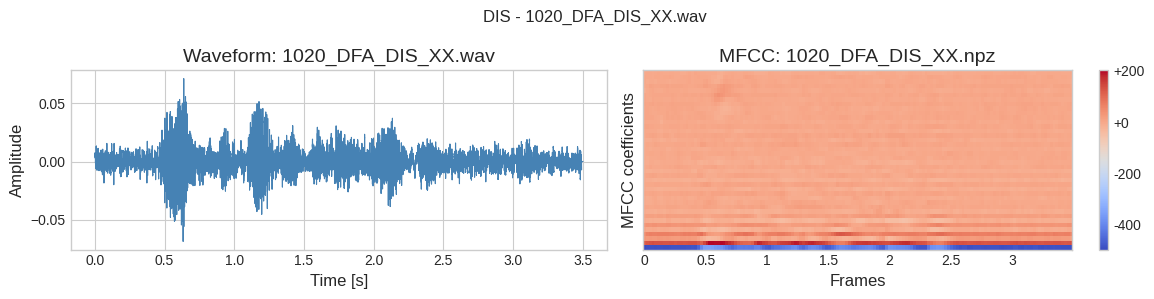

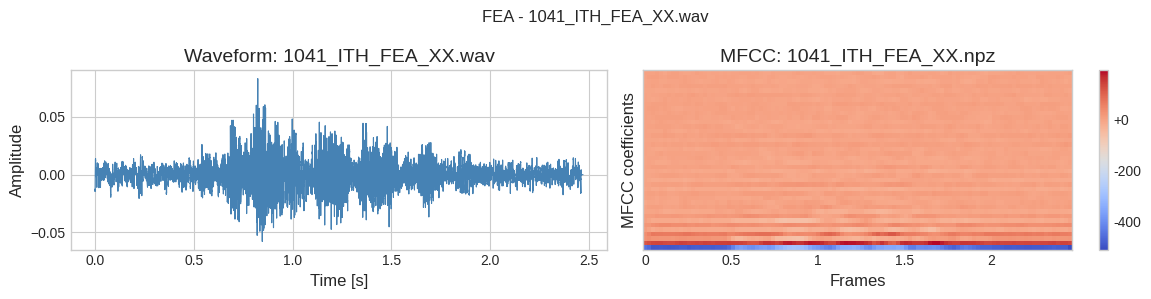

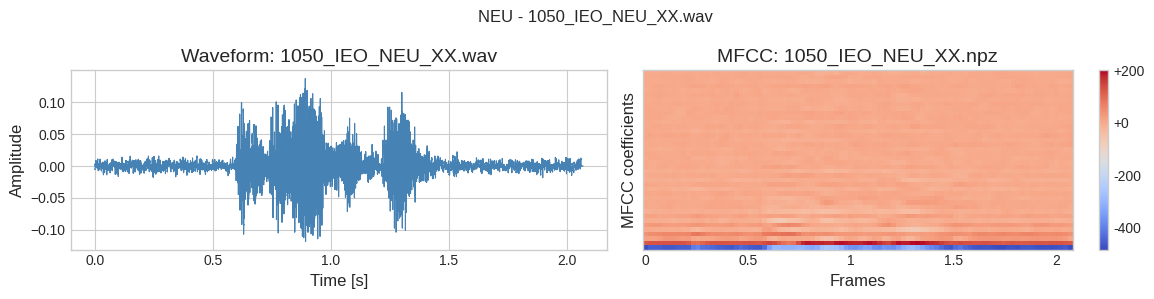

In [23]:

# Example waveforms with MFCC matrices
if 'mfcc' in locals().get('mfcc_store', {}):
    mfcc_meta = mfcc_store['mfcc']['meta']
    mfcc_examples = []
    for cls in SELECTED_CLASSES:
        cls_df = mfcc_meta[mfcc_meta['label'] == cls]
        if not cls_df.empty:
            mfcc_examples.append(cls_df.sample(n=1, random_state=SEED))

    if mfcc_examples:
        audio_lookup = meta_df.set_index('file_stem')['file_path'] if 'meta_df' in globals() else None
        for _, row in pd.concat(mfcc_examples).iterrows():
            audio_path = None
            if audio_lookup is not None and row['file_stem'] in audio_lookup.index:
                audio_path = audio_lookup.loc[row['file_stem']]
            plot_example_waveform_and_mfcc(row, audio_path=audio_path)
    else:
        print('No MFCC examples available for the selected classes.')
else:
    print('MFCC store is empty; skipping MFCC waveform examples.')


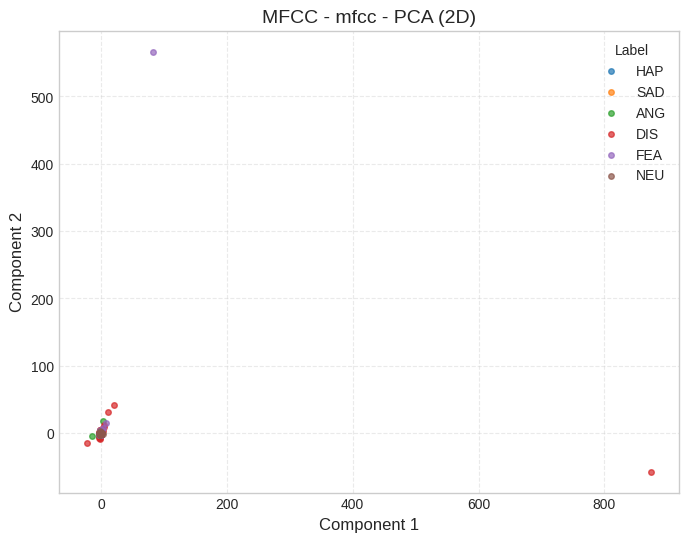

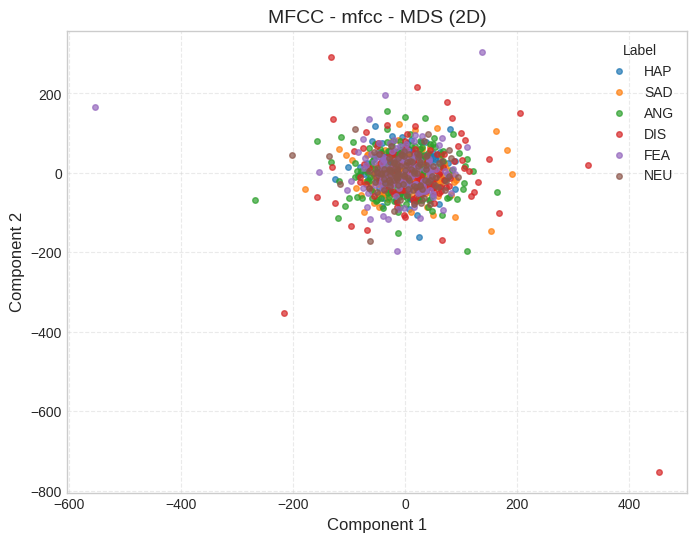

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


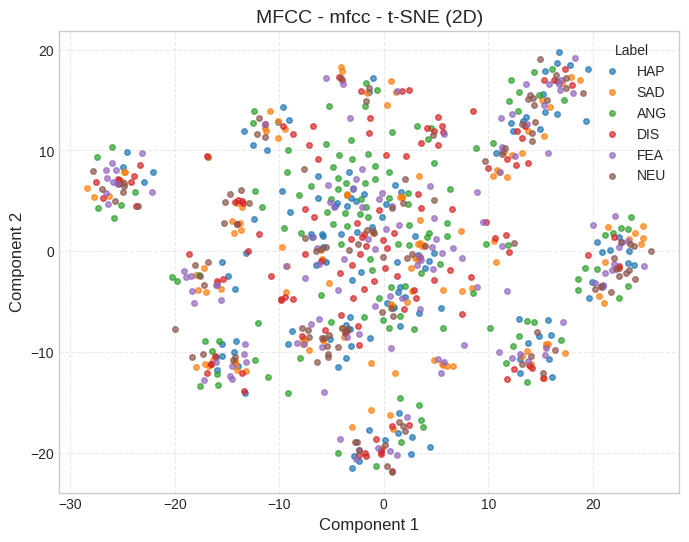

In [24]:

# Dimensionality reduction projections for MFCC features
if not mfcc_store:
    print('MFCC features not loaded; skipping MFCC dimensionality reduction.')
else:
    mfcc_pca_results = {}
    for feat_type, payload in mfcc_store.items():
        X, y = payload['X'], payload['y']
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        n_comp = min(PCA_COMPONENTS_MAX, X_scaled.shape[1], X_scaled.shape[0])
        pca, X_pca = run_dim_reduction(
            X_scaled,
            method='pca',
            n_components=n_comp,
            scale=False,
            random_state=SEED
        )
        mfcc_pca_results[feat_type] = {'pca': pca, 'X_pca': X_pca, 'y': y}
        plot_2d_projection(X_pca[:, :2], y, title=f'MFCC - {feat_type} - PCA (2D)', label_order=SELECTED_CLASSES)

        X_sub, y_sub, _ = subsample_for_viz(X_scaled, y, max_samples=MAX_VIZ_SAMPLES, random_state=SEED)
        _, X_mds = run_dim_reduction(
            X_sub,
            method='mds',
            n_components=2,
            scale=False,
            random_state=SEED,
            n_init=4,
            max_iter=300
        )
        plot_2d_projection(X_mds, y_sub, title=f'MFCC - {feat_type} - MDS (2D)', label_order=SELECTED_CLASSES)

        tsne_perp = resolve_tsne_perplexity(len(X_sub))
        _, X_tsne = run_dim_reduction(
            X_sub,
            method='tsne',
            n_components=2,
            scale=False,
            random_state=SEED,
            perplexity=tsne_perp,
            init='pca',
            learning_rate='auto',
            n_iter=1000
        )
        plot_2d_projection(X_tsne, y_sub, title=f'MFCC - {feat_type} - t-SNE (2D)', label_order=SELECTED_CLASSES)


In [ ]:
# Baseline classifiers and confusion matrix utilities are imported from src.analysis_utils and src.plot_functions.

>>> Baselines for resnet18
[load_feature_arrays] 1 files failed to load from /content/drive/MyDrive/CREMAD/Embeddings/ResNet18.
  Example errors: [('/content/drive/MyDrive/CREMAD/Embeddings/ResNet18/train/HAP/1030_IWL_HAP_XX.npz', "EOFError('No data left in file')")]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression ===
Accuracy: 0.469
              precision    recall  f1-score   support

         HAP       0.44      0.46      0.45       255
         SAD       0.48      0.49      0.48       254
         ANG       0.61      0.64      0.63       254
         DIS       0.39      0.36      0.38       254
         FEA       0.40      0.37      0.38       254
         NEU       0.47      0.51      0.49       218

    accuracy                           0.47      1489
   macro avg       0.47      0.47      0.47      1489
weighted avg       0.47      0.47      0.47      1489

=== Perceptron ===
Accuracy: 0.406
              precision    recall  f1-score   support

         HAP       0.37      0.39      0.38       255
         SAD       0.51      0.38      0.43       254
         ANG       0.53      0.52      0.53       254
         DIS       0.35      0.40      0.37       254
         FEA       0.31      0.36      0.34       254
         NEU       0.44      0.39      0.41       218

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


=== MLP (64,) ===
Accuracy: 0.465
              precision    recall  f1-score   support

         HAP       0.44      0.44      0.44       255
         SAD       0.47      0.49      0.48       254
         ANG       0.59      0.59      0.59       254
         DIS       0.41      0.40      0.40       254
         FEA       0.37      0.37      0.37       254
         NEU       0.52      0.51      0.51       218

    accuracy                           0.47      1489
   macro avg       0.47      0.47      0.47      1489
weighted avg       0.47      0.47      0.47      1489



,model,accuracy
0,Logistic Regression,0.469443
1,Perceptron,0.406313
2,"MLP (64,)",0.465413


>>> Baselines for vgg16


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression ===
Accuracy: 0.400
              precision    recall  f1-score   support

         HAP       0.36      0.37      0.37       255
         SAD       0.44      0.43      0.43       254
         ANG       0.56      0.55      0.55       254
         DIS       0.29      0.33      0.31       254
         FEA       0.33      0.31      0.32       254
         NEU       0.45      0.41      0.43       218

    accuracy                           0.40      1489
   macro avg       0.41      0.40      0.40      1489
weighted avg       0.40      0.40      0.40      1489

=== Perceptron ===
Accuracy: 0.367
              precision    recall  f1-score   support

         HAP       0.30      0.32      0.31       255
         SAD       0.42      0.37      0.39       254
         ANG       0.50      0.52      0.51       254
         DIS       0.26      0.29      0.28       254
         FEA       0.32      0.31      0.31       254
         NEU       0.43      0.39      0.41       218

,model,accuracy
0,Logistic Regression,0.400269
1,Perceptron,0.366689
2,"MLP (64,)",0.431833


>>> Baselines for panns_cnn14


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression ===
Accuracy: 0.453
              precision    recall  f1-score   support

         HAP       0.41      0.42      0.42       255
         SAD       0.45      0.43      0.44       254
         ANG       0.60      0.61      0.60       254
         DIS       0.39      0.35      0.37       254
         FEA       0.39      0.41      0.40       254
         NEU       0.47      0.51      0.49       218

    accuracy                           0.45      1489
   macro avg       0.45      0.45      0.45      1489
weighted avg       0.45      0.45      0.45      1489

=== Perceptron ===
Accuracy: 0.429
              precision    recall  f1-score   support

         HAP       0.39      0.32      0.35       255
         SAD       0.40      0.42      0.41       254
         ANG       0.59      0.67      0.63       254
         DIS       0.37      0.30      0.33       254
         FEA       0.38      0.35      0.37       254
         NEU       0.40      0.53      0.46       218

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,accuracy
0,Logistic Regression,0.453324
1,Perceptron,0.429147
2,"MLP (64,)",0.465413


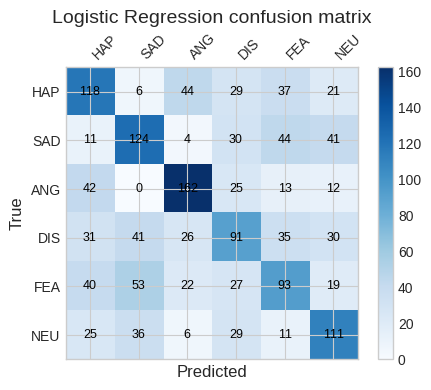

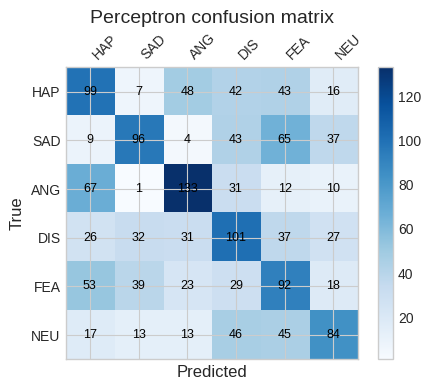

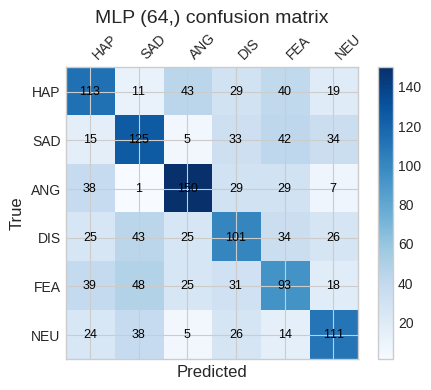

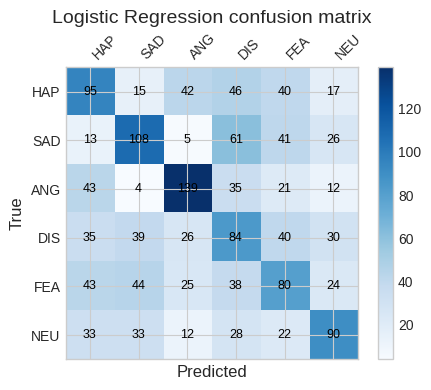

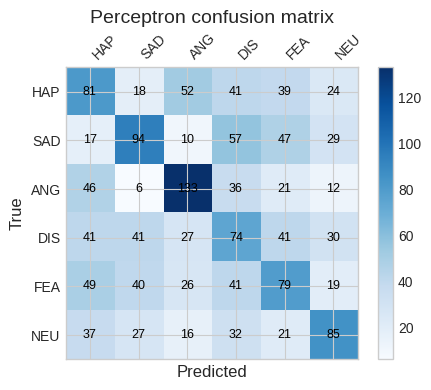

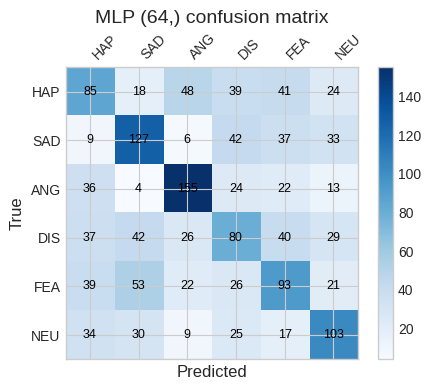

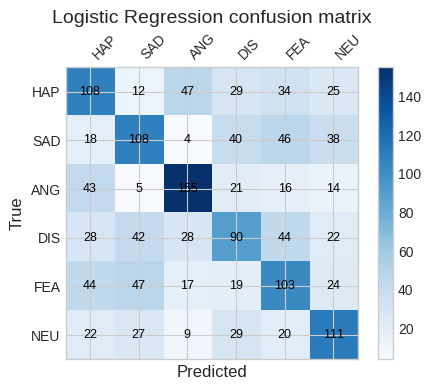

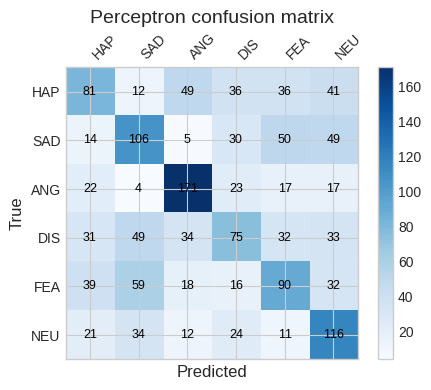

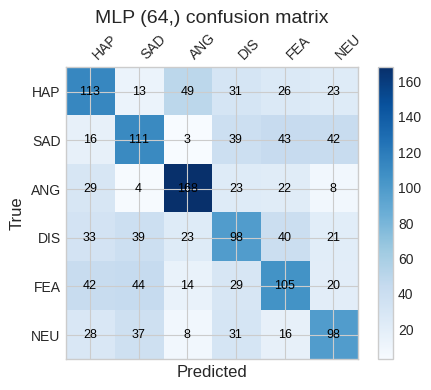

In [26]:
# Run baselines for each embedding type
baseline_results = {}
for emb_type in EMBEDDING_TYPES:
    print(f'>>> Baselines for {emb_type}')
    X_train, y_train, _ = load_embeddings(emb_type, splits=['train'], embedding_paths=EMBEDDING_PATHS, selected_classes=SELECTED_CLASSES)
    X_test, y_test, _ = load_embeddings(emb_type, splits=['test'], embedding_paths=EMBEDDING_PATHS, selected_classes=SELECTED_CLASSES)
    results_df = run_baseline_classifiers(X_train, y_train, X_test, y_test, SELECTED_CLASSES)
    baseline_results[emb_type] = results_df
    display(results_df)


## Summary

- Embedding dimensionalities, PCA coverage, and baseline accuracies above provide a quick sanity check before hybrid models.
- Components needed for 90?95% variance guide downstream dimensionality reduction choices.
- Visual separability in PCA 2D often correlates with how well classical baselines perform on the selected emotions.
    